In [1]:
import pandas as pd
import numpy as np
import collections as clt
import networkx as nx
import matplotlib.pyplot as plt
import itertools

In [2]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [3]:
df = pd.read_csv('reviews_full_v9-2.csv')
df.head()

,User,Date,Year,Month,Release,Band,Score,Link,Album_link,Review_title,...,Band_Genre,Combined_Genre,Key Features,Cleansed Features,Cleansed Text,Product Features,Product Features_dep,neg,neu,pos
0,SpookyApparition,July 11 2002,2002,7,Chaosphere,Meshuggah,82,https://www.metal-archives.com/reviews/Meshugg...,https://www.metal-archives.com/albums/Meshugga...,Technical metal at it's finest.,...,groove metal|thrash metal,technical thrash metal|math metal|progressive ...,originally bought|entire album|sounded variati...,originally bought|entire album|sounded variati...,I originally bought Chaosphere in late 2000......,entire album|sounded variation|grown appreciat...,tacky place|respective instruments|vocal perfo...,0.025,0.826,0.149
1,SpookyApparition,July 14 2002,2002,7,Necroticism_-_Descanting_the_Insalubrious,Carcass,88,https://www.metal-archives.com/reviews/Carcass...,https://www.metal-archives.com/albums/Carcass/...,Carcass at their finest.,...,grindcore|death metal,grindcore|melodic death metal,somewhat song structures|song structures|injec...,somewhat song structures|song structures|injec...,A midpoint between Carcass' early grind albums...,somewhat song structures|song structures|injec...,melodic variety|vocal performances|enjoyable a...,0.038,0.850,0.111
2,MarkRyan,July 15 2002,2002,7,Angels_Fall_First,Nightwish,90,https://www.metal-archives.com/reviews/Nightwi...,https://www.metal-archives.com/albums/Nightwis...,On par with their other stuff...,...,symphonic metal|power metal,symphonic power metal,general consensus|lose credibility|sung poet|b...,general consensus|lose credibility|sung poet|b...,"I'm not hard-core into metal at all, really, b...",general consensus|lose credibility|sung poet|b...,beautiful melody|beautiful example|general con...,0.026,0.771,0.202
3,Fear,July 16 2002,2002,7,Dark_Genesis,Iced_Earth,87,https://www.metal-archives.com/reviews/Iced_Ea...,https://www.metal-archives.com/albums/Iced_Ear...,Brilliance in Repackaging,...,thrash metal|power metal,heavy metal|us power metal,new album fact|old material|bought big fan|big...,new album fact|old material|bought big fan|big...,"This is not a new album, but in fact, five alb...",new album fact|old material|bought big fan|big...,different versions|original vocals|old materia...,0.031,0.723,0.246
4,Esoteric,July 16 2002,2002,7,A_Night_at_the_Opera,Blind_Guardian,70,https://www.metal-archives.com/reviews/Blind_G...,https://www.metal-archives.com/albums/Blind_Gu...,Somewhat Disappointing,...,speed metal|power metal,power metal,accurate description album|vocal lines|meaty a...,accurate description album|vocal lines|meaty a...,I've been trying for months to come up with an...,accurate description album|vocal lines|meaty a...,catchy songs|bad album|vocal lines|little line...,0.130,0.747,0.123


In [19]:
B = nx.Graph()
D = nx.DiGraph()
userset = set()
#userset = set(df.User)
#B.add_nodes_from(userset)
#D.add_nodes_from(userset)


for i,row in df.iterrows():
    if row.Score < 75:
        continue
    B.add_edge(row.User, row.Release + 'R')
    userset.add(row.User)

In [20]:
#userset = list(userset)
#userset = sorted(userset, key = lambda x: B.degree(x), reverse = True)

In [21]:
for user in userset:
    users = userset.copy()
    for album in B.adj[user]:
        users = users.intersection(set(B.adj[album]))
    for root in users:
        if not D.has_edge(user, root) and not D.has_edge(root, user) and root != user: #just in case two users have same set of albums
            D.add_edge(root, user)    

In [22]:
roots = sorted([node for node in D.nodes() if D.in_degree(node) == 0], key = lambda x: D.out_degree(x))

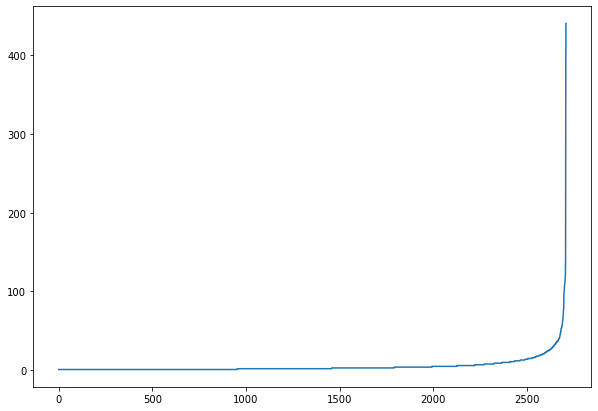

(8639, 2710, 678)

In [23]:
plt.plot([D.out_degree(root) for root in roots])
plt.show()
len(userset), len(roots), len(set(df.User).difference(userset))